In [ ]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-ymlump49
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-ymlump49
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65173 sha256=abea13238a0aaf1979e2972f22d78f9415b70906e93898ba94206ebc861969f6
  Stored in directory: /tmp/pip-ephem-wheel-cache-7ghxh38n/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.5
    Uninstalling albumentations-0.4.5:
      Successfully uninstalled albumentations-0.4.5


In [ ]:
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (HorizontalFlip,OpticalDistortion,VerticalFlip,GridDistortion,RandomBrightnessContrast,OneOf,ElasticTransform,RandomGamma,IAAEmboss,Blur,RandomRotate90,Transpose, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise,MultiplicativeNoise)
from albumentations.pytorch import ToTensor
warnings.filterwarnings("ignore")

In [ ]:
import albumentations as A

In [ ]:
A.MultiplicativeNoise()

MultiplicativeNoise(always_apply=False, p=0.5, multiplier=(0.9, 1.1), per_channel=False, elementwise=False)

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch > /dev/null 2>&1

In [ ]:
import segmentation_models_pytorch as smp

In [ ]:
def run_length_decode(rle, height=1024, width=1024, fill_value=1):
    component = np.zeros((height, width), np.float32)
    component = component.reshape(-1)
    rle = np.array([int(s) for s in rle.strip().split(' ')])
    rle = rle.reshape(-1, 2)
    start = 0
    for index, length in rle:
        start = start+index
        end = start+length
        component[start: end] = fill_value
        start = end
    component = component.reshape(width, height).T
    return component

def run_length_encode(component):
    component = component.T.flatten()
    start = np.where(component[1:] > component[:-1])[0]+1
    end = np.where(component[:-1] > component[1:])[0]+1
    length = end-start
    rle = []
    for i in range(len(length)):
        if i == 0:
            rle.extend([start[0], length[0]])
        else:
            rle.extend([start[i]-end[i-1], length[i]])
    rle = ' '.join([str(r) for r in rle])
    return rle

In [ ]:
class SIIMDataset(Dataset):
    def __init__(self, df, fnames, data_folder, size, mean, std, phase):
        self.df = df
        self.root = data_folder
        self.size = size
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, size, mean, std)
        self.gb = self.df.groupby('ImageId')
        self.fnames = fnames

    def __getitem__(self, idx):
        image_id = self.fnames[idx]
        df = self.gb.get_group(image_id)
        annotations = df[' EncodedPixels'].tolist()
        image_path = os.path.join(self.root, image_id + ".png")
        image = cv2.imread(image_path)
        mask = np.zeros([1024, 1024])
        if annotations[0] != '-1':
            for rle in annotations:
                mask += run_length_decode(rle)
        mask = (mask >= 1).astype('float32') # for overlap cases
        augmented = self.transforms(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        return image, mask

    def __len__(self):
        return len(self.fnames)


def get_transforms(phase, size, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                 HorizontalFlip(p=0.5),
                ShiftScaleRotate(
                    shift_limit=0,  # no resizing
                    scale_limit=0.1,
                    rotate_limit=10, # rotate
                    p=0.5,
                    border_mode=cv2.BORDER_CONSTANT
                ),
                 GaussNoise(),
                A.MultiplicativeNoise(multiplier=1.5, p=1),
            ]
        )
    list_transforms.extend(
        [
            Resize(size, size),
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )

    list_trfms = Compose(list_transforms)
    return list_trfms

def provider(
    fold,
    total_folds,
    data_folder,
    df_path,
    phase,
    size,
    mean=None,
    std=None,
    batch_size=8,
    num_workers=2,
):
    df_all = pd.read_csv(df_path)
    df = df_all.drop_duplicates('ImageId')
    df_with_mask = df[df[" EncodedPixels"] != "-1"]
    df_with_mask['has_mask'] = 1
    df_without_mask = df[df[" EncodedPixels"] == "-1"]
    df_without_mask['has_mask'] = 0
    df_without_mask_sampled = df_without_mask.sample(len(df_with_mask)+1500, random_state=2019) # random state is imp
    df = pd.concat([df_with_mask, df_without_mask_sampled])
     #NOTE: equal number of positive and negative cases are chosen.
    
    kfold = StratifiedKFold(total_folds, shuffle=True, random_state=43)
    train_idx, val_idx = list(kfold.split(df["ImageId"], df["has_mask"]))[fold]
    train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]
    df = train_df if phase == "train" else val_df
    # NOTE: total_folds=5 -> train/val : 80%/20%
    
    fnames = df['ImageId'].values
    
    image_dataset = SIIMDataset(df_all, fnames, data_folder, size, mean, std, phase)

    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )
    return dataloader

In [ ]:
sample_submission_path = './input/stage_2_sample_submission.csv'
train_rle_path = './input/train-rle.csv'
data_train = './input/train_png'
test_data_folder = './input/siim_stage2_png'

In [ ]:
import glob
ab = glob.glob(data_train+'/*.png')
len(ab)

12089

In [ ]:
a= pd.read_csv(train_rle_path)
len(a)

12047

In [ ]:
dataloader = provider(
    fold=0,
    total_folds=5,
    data_folder=data_train,
    df_path=train_rle_path,
    phase="train",
    size=512,
    mean = (0.485, 0.456, 0.406),
    std = (0.229, 0.224, 0.225),
    batch_size=16,
    num_workers=2,
)

In [ ]:
batch = next(iter(dataloader)) # get a batch from the dataloader
images, masks = batch

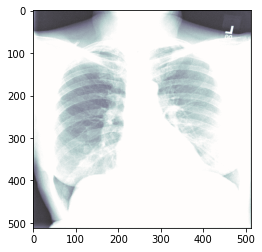

Chosen image has no ground truth mask, rerun the cell


In [ ]:
# plot some random images in the `batch`
idx = random.choice(range(16))
plt.imshow(images[idx][0], cmap='bone')
plt.imshow(masks[idx][0], alpha=0.2, cmap='Reds')
plt.show()
if len(np.unique(masks[idx][0])) == 1: # only zeros
    print('Chosen image has no ground truth mask, rerun the cell')

In [ ]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()


class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [ ]:
def predict(X, threshold):
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

def metric(probability, truth, threshold=0.5, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
        dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
        dice = dice.mean().item()

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.append(dice)
        self.dice_pos_scores.append(dice_pos)
        self.dice_neg_scores.append(dice_neg)
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.mean(self.base_dice_scores)
        dice_neg = np.mean(self.dice_neg_scores)
        dice_pos = np.mean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
        iou = np.nanmean(self.iou_scores)
        return dices, iou

def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    dices, iou = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print("Loss: %0.4f | dice: %0.4f | dice_neg: %0.4f | dice_pos: %0.4f | IoU: %0.4f" % (epoch_loss, dice, dice_neg, dice_pos, iou))
    return dice, iou

def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]


def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou

In [ ]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
model = smp.FPN('inceptionresnetv2', encoder_weights="imagenet")

In [ ]:
model

FPN(
  (encoder): InceptionResNetV2Encoder(
    (conv2d_1a): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2a): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2b): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=(1, 1), dilation=1, ceil_mode=False)
    (conv2d_3b): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, ep

In [ ]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

In [ ]:
class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self, model):
        self.fold = 1
        self.total_folds = 5
        self.num_workers = 4
        self.batch_size = {"train": 4, "val": 4}
        self.accumulation_steps = 32 // self.batch_size['train']
        self.lr = 5e-4
        self.num_epochs = 20
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        self.criterion = MixedLoss(10.0, 2.0)
        #self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        self.optimizer = RAdam(model.parameters(), lr=self.lr)

        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=3, verbose=True)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        self.dataloaders = {
            phase: provider(
                fold=1,
                total_folds=5,
                data_folder=data_train,
                df_path=train_rle_path,
                phase=phase,
                size=512,
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        
    def forward(self, images, targets):
        images = images.to(self.device)
        masks = targets.to(self.device)
        outputs = self.net(images)
        loss = self.criterion(outputs, masks)
        return loss, outputs

    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size[phase]
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
#         tk0 = tqdm(dataloader, total=total_batches)
        self.optimizer.zero_grad()
        for itr, batch in enumerate(dataloader):
            images, targets = batch
            loss, outputs = self.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)
#             tk0.set_postfix(loss=(running_loss / ((itr + 1))))
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        dice, iou = epoch_log(phase, epoch, epoch_loss, meter, start)
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(dice)
        self.iou_scores[phase].append(iou)
        torch.cuda.empty_cache()
        return epoch_loss

    def start(self):
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            val_loss = self.iterate(epoch, "val")
            self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, "./model.pth")
            print()

In [ ]:
model_trainer = Trainer(model)
model_trainer.start()

Starting epoch: 0 | phase: train | ⏰: 07:12:06
Loss: 4.1900 | dice: 0.2547 | dice_neg: 0.3186 | dice_pos: 0.1339 | IoU: 0.0996
Starting epoch: 0 | phase: val | ⏰: 07:22:16
Loss: 2.8027 | dice: 0.3373 | dice_neg: 0.3572 | dice_pos: 0.2557 | IoU: 0.1987
******** New optimal found, saving state ********

Starting epoch: 1 | phase: train | ⏰: 07:23:09
Loss: 2.8927 | dice: 0.3816 | dice_neg: 0.4591 | dice_pos: 0.2472 | IoU: 0.1928
Starting epoch: 1 | phase: val | ⏰: 07:33:11
Loss: 2.4362 | dice: 0.4499 | dice_neg: 0.5166 | dice_pos: 0.2876 | IoU: 0.2306
******** New optimal found, saving state ********

Starting epoch: 2 | phase: train | ⏰: 07:34:02
Loss: 2.6980 | dice: 0.4562 | dice_neg: 0.5464 | dice_pos: 0.2687 | IoU: 0.2177
Starting epoch: 2 | phase: val | ⏰: 07:44:07
Loss: 2.8415 | dice: 0.4939 | dice_neg: 0.5636 | dice_pos: 0.2789 | IoU: 0.2269

Starting epoch: 3 | phase: train | ⏰: 07:44:57
Loss: 2.5373 | dice: 0.5183 | dice_neg: 0.6293 | dice_pos: 0.2967 | IoU: 0.2433
Starting epoch

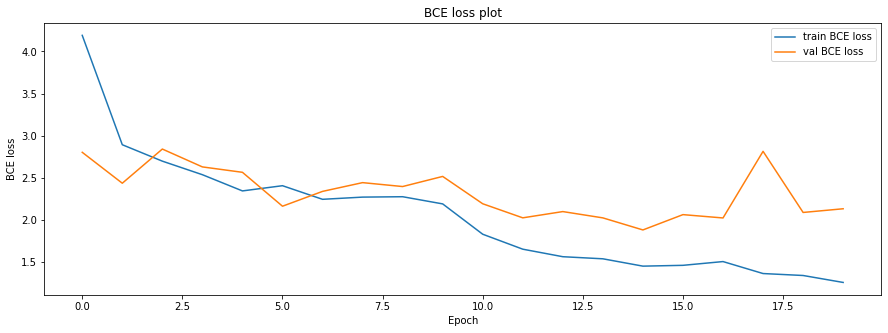

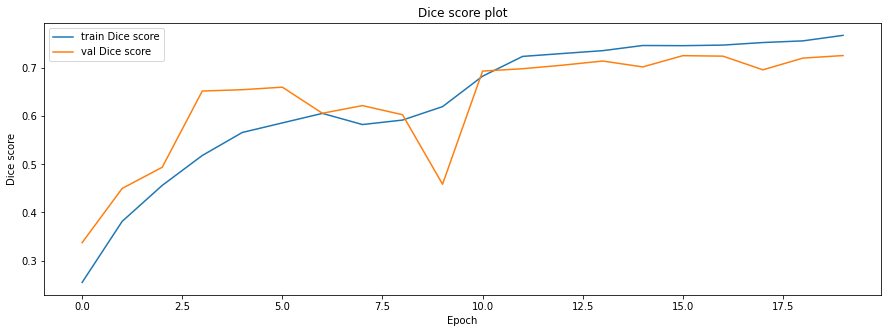

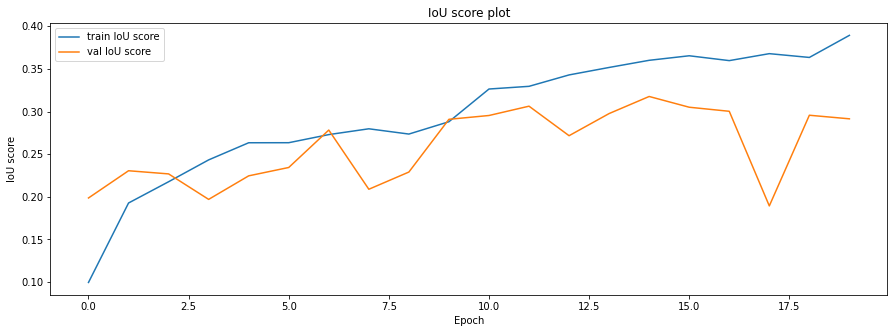

In [ ]:
# PLOT TRAINING
losses = model_trainer.losses
dice_scores = model_trainer.dice_scores # overall dice
iou_scores = model_trainer.iou_scores

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

plot(losses, "BCE loss")
plot(dice_scores, "Dice score")
plot(iou_scores, "IoU score")

In [ ]:
class TestDataset(Dataset):
    def __init__(self, root, df, size, mean, std, tta=4):
        self.root = root
        self.size = size
        self.fnames = list(df["ImageId"])
        self.num_samples = len(self.fnames)
        self.transform = Compose(
            [
                Normalize(mean=mean, std=std, p=1),
                Resize(size, size),
                ToTensor(),
            ]
        )

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        path = os.path.join(self.root, fname + ".png")
        image = cv2.imread(path)
        images = self.transform(image=image)["image"]
        return images

    def __len__(self):
        return self.num_samples

def post_process(probability, threshold, min_size):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((1024, 1024), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [ ]:
size = 512
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
num_workers = 8
batch_size = 2
best_threshold = 0.5
min_size = 3500
device = torch.device("cuda:0")
df = pd.read_csv(sample_submission_path)
testset = DataLoader(
    TestDataset(test_data_folder, df, size, mean, std),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)
model = model_trainer.net # get the model from model_trainer object
model.eval()
state = torch.load('./model.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])
encoded_pixels = []
for i, batch in enumerate(tqdm(testset)):
    preds = torch.sigmoid(model(batch.to(device)))
    preds = preds.detach().cpu().numpy()[:, 0, :, :] # (batch_size, 1, size, size) -> (batch_size, size, size)
    for probability in preds:
        if probability.shape != (1024, 1024):
            probability = cv2.resize(probability, dsize=(1024, 1024), interpolation=cv2.INTER_LINEAR)
        predict, num_predict = post_process(probability, best_threshold, min_size)
        if num_predict == 0:
            encoded_pixels.append('-1')
        else:
            r = run_length_encode(predict)
            encoded_pixels.append(r)
df['EncodedPixels'] = encoded_pixels
df.to_csv(sample_submission_path, columns=['ImageId', 'EncodedPixels'], index=False)


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5f76a8fb38>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


In [ ]:
df.head()

,ImageId,EncodedPixels,EncodedPixels
0,ID_0011fe81e,-1,-1
1,ID_9ca06e9b9,-1,-1
2,ID_6f00d6ce6,-1,-1
3,ID_9258110b0,-1,-1
4,ID_fa01c9546,-1,319752 4 1014 14 1007 19 1004 21 45 3 954 22 4...
